# NYC Taxi - Data exploration and cleaning

This notebook solves the following activities:

- Download and assess the data
- Identify and document any issues with the data
- Document how you resolved these issues

In [2]:
# import libraries
import extraction as ext
import preprocessing as prep
import importlib
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
import yaml
import matplotlib.pyplot as plt

### Extract data

In [3]:
# get parameters from config.yml file
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

spark = SparkSession \
    .builder \
    .appName("NYC Taxi") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled","true")        

psdf_taxi = ext.get_taxi_data(spark, cfg)
df_zones = ext.get_zones(cfg)
gdf_zones_shp = ext.get_zones_shapefile(cfg)

Already downloaded file: yellow_tripdata_2017-01.parquet
Already downloaded file: yellow_tripdata_2017-03.parquet
Already downloaded file: yellow_tripdata_2017-06.parquet
Already downloaded file: yellow_tripdata_2017-11.parquet
Already downloaded file: yellow_tripdata_2017-12.parquet
Already downloaded file: taxi+_zone_lookup.csv
Already downloaded file: taxi_zones.shp


### Add new features

In [4]:
# Calculate the duration of the trip in a new feature 'duration_in_min'
psdf_taxi = psdf_taxi.withColumn('duration_in_min', 
    func.round((psdf_taxi["tpep_dropoff_datetime"].cast("long") 
    - psdf_taxi["tpep_pickup_datetime"].cast("long"))/60,1))

### Clean non accepted values

In [5]:
# we accept > 0 values
for col in ["passenger_count", "trip_distance", "fare_amount", 
            "total_amount", "duration_in_min"]:
      psdf_taxi = psdf_taxi.withColumn(col, \
            func.when(psdf_taxi[col] > 0, \
            psdf_taxi[col]).otherwise(func.lit(None)))

# we accept >= 0 values
for col in ["extra", "tip_amount", "tolls_amount"]:
      psdf_taxi = psdf_taxi.withColumn(col, \
            func.when(psdf_taxi[col] >= 0, \
            psdf_taxi[col]).otherwise(func.lit(None)))

# values allowed with mod 0.5.    
psdf_taxi = psdf_taxi.withColumn("extra", \
      func.when(psdf_taxi.extra % 0.5 == 0, \
      psdf_taxi.extra).otherwise(func.lit(None)))

psdf_taxi = psdf_taxi.withColumn("mta_tax", \
      func.when(psdf_taxi.mta_tax.isin([0, 0.5]), \
      psdf_taxi.mta_tax).otherwise(func.lit(None)))

psdf_taxi = psdf_taxi.withColumn("improvement_surcharge", \
      func.when(psdf_taxi.improvement_surcharge == 0.3, \
      psdf_taxi.improvement_surcharge).otherwise(func.lit(None)))

psdf_taxi = psdf_taxi.withColumn("RateCodeID", \
      func.when(psdf_taxi["RateCodeID"].isin([1,2,3,4,5,6]), \
      psdf_taxi["RateCodeID"]).otherwise(func.lit(None)))

In [6]:
psdf_taxi = psdf_taxi.withColumn('pu_month', func.month(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('pu_year', func.year(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('do_month', func.month(psdf_taxi.tpep_dropoff_datetime))
psdf_taxi = psdf_taxi.withColumn('do_year', func.year(psdf_taxi.tpep_dropoff_datetime))


for column in ["do_year", "pu_year"]:
    psdf_taxi = psdf_taxi.withColumn(column, \
        func.when(psdf_taxi[column].isin(cfg["extraction"]["yellow_taxi"]["years"]), \
        psdf_taxi[column]).otherwise(func.lit(None)))
    
for column in ["do_month", "pu_month"]:
        psdf_taxi = psdf_taxi.withColumn(column, \
        func.when(psdf_taxi[column].isin(cfg["extraction"]["yellow_taxi"]["months"]), \
        psdf_taxi[column]).otherwise(func.lit(None)))



### Main statistics

In [7]:
df_basic_stats = psdf_taxi.sample(0.05).toPandas() 
print(f"Total rows:{psdf_taxi.count()}")
print(f"Total sample rows:{len(df_basic_stats)}")

Total rows:4846159
Total sample rows:243026


In [8]:
# check number of null values
print("Null values")
psdf_taxi.select([(func.count(func.when(func.isnan(c) | \
    func.isnull(c), c))).\
    alias(c) for (c,c_type) in psdf_taxi.dtypes \
    if c_type not in ('timestamp', 'string', 'date')]).show()

Null values
+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+--------+-------+--------+-------+
|VendorID|passenger_count|trip_distance|RateCodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|duration_in_min|pu_month|pu_year|do_month|do_year|
+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+--------+-------+--------+-------+
|       0|          11193|        30975|        76|           0|           0|           0|       3751| 1374|   2385|        35|          13|                 3557|        2900|             4846159|    4846159|   

- congestion_surcharge and airport_fee have all values null, so we will remove them 

In [9]:
columns_to_drop = ['airport_fee', 'congestion_surcharge']
psdf_taxi = psdf_taxi.drop(*columns_to_drop)

VendorID
+--------+-------+
|VendorID|  count|
+--------+-------+
|       1|2193809|
|       2|2652350|
+--------+-------+

+--------+---+---+---+----+----+---+------+
|VendorID| 0%| 5%|25%| 50%| 75%|95%|  100%|
+--------+---+---+---+----+----+---+------+
|       1|0.0|0.0|0.0|1.35|2.35|6.0| 250.0|
|       2|0.0|0.0|0.0|1.36|2.46|6.7|376.79|
+--------+---+---+---+----+----+---+------+



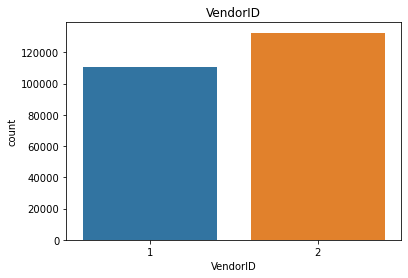

RateCodeID
+----------+-------+
|RateCodeID|  count|
+----------+-------+
|      null|     76|
|         1|4713038|
|         2| 104590|
|         3|   9843|
|         4|   2548|
|         5|  16033|
|         6|     31|
+----------+-------+

+----------+---+---+---+----+------+-------+------+
|RateCodeID| 0%| 5%|25%| 50%|   75%|    95%|  100%|
+----------+---+---+---+----+------+-------+------+
|      null|0.0|0.0|0.0| 0.0|   0.0|   8.25|  21.5|
|         1|0.0|0.0|0.0|1.35|  2.35|   5.26|376.79|
|         2|0.0|0.0|0.0|10.0| 11.71|  14.64| 250.0|
|         3|0.0|0.0|0.0|12.0|16.895|  22.45| 160.0|
|         4|0.0|0.0|0.0| 5.0| 14.46|25.8395| 67.65|
|         5|0.0|0.0|0.0| 2.0|  11.5|   25.0| 185.0|
|         6|0.0|0.0|0.0| 0.0|   0.0|    0.0|  0.95|
+----------+---+---+---+----+------+-------+------+



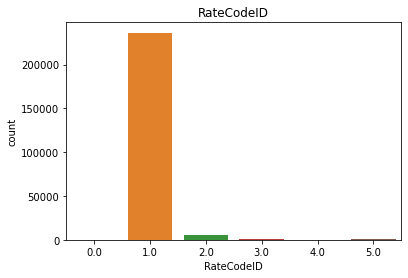

store_and_fwd_flag
+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|4825857|
|                 Y|  20302|
+------------------+-------+

+------------------+---+---+---+----+----+---+------+
|store_and_fwd_flag| 0%| 5%|25%| 50%| 75%|95%|  100%|
+------------------+---+---+---+----+----+---+------+
|                 N|0.0|0.0|0.0|1.36|2.45|6.3|376.79|
|                 Y|0.0|0.0|0.0|1.35|2.95|9.6|  95.0|
+------------------+---+---+---+----+----+---+------+



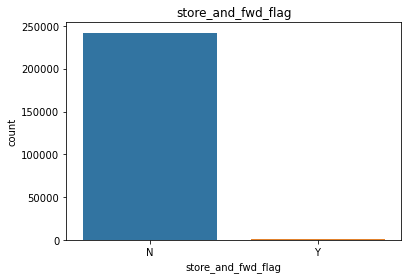

payment_type
+------------+-------+
|payment_type|  count|
+------------+-------+
|           1|3265681|
|           2|1547816|
|           3|  25496|
|           4|   7166|
+------------+-------+

+------------+---+----+----+---+----+---+------+
|payment_type| 0%|  5%| 25%|50%| 75%|95%|  100%|
+------------+---+----+----+---+----+---+------+
|           1|0.0|0.63|1.35|2.0|3.05|8.0|376.79|
|           2|0.0| 0.0| 0.0|0.0| 0.0|0.0| 20.65|
|           3|0.0| 0.0| 0.0|0.0| 0.0|0.0|  6.72|
|           4|0.0| 0.0| 0.0|0.0| 0.0|0.0|  2.96|
+------------+---+----+----+---+----+---+------+



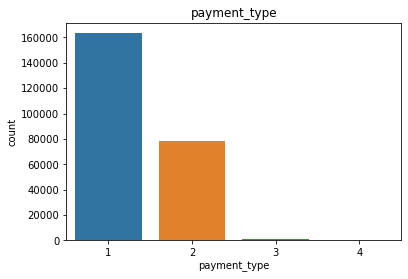

In [10]:
importlib.reload(prep)

category_columns = ["VendorID", 
    "RateCodeID", "store_and_fwd_flag", 
    "payment_type"] 

for column in category_columns:
    print(column)
    psdf_taxi.groupby(column).count().orderBy(column).show()
    prep.show_grouped_percentiles(psdf_taxi, column, "tip_amount")
    sns.countplot(x = column, data=df_basic_stats)
    plt.title(column);  
    plt.show()  

- payment_type different from 1 gives not valid tip values. We remove them.


In [11]:
# only keep card payments since other payments does not includ valid tip values
psdf_taxi = psdf_taxi.filter(psdf_taxi.payment_type == 1)
df_basic_stats = psdf_taxi.sample(0.05).toPandas() 

passenger_count
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%|95%|99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
|1.0| 1.0| 1.0|1.0|1.0|1.0|1.0|1.0|2.0|3.0|5.0|6.0|  6.0|  6.0| 9.0|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+



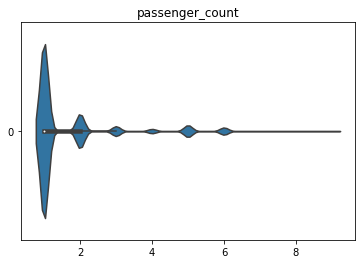

trip_distance
+----+----+----+---+----+---+---+---+----+----+-----+----+-----+-----+-----+
|  0%|0.1%|0.5%| 1%|  5%|10%|25%|50%| 75%| 90%|  95%| 99%|99.5%|99.9%| 100%|
+----+----+----+---+----+---+---+---+----+----+-----+----+-----+-----+-----+
|0.01| 0.1|0.28|0.3|0.51|0.7|1.0|1.7|3.19|7.18|10.99|19.0| 20.6|26.15|338.2|
+----+----+----+---+----+---+---+---+----+----+-----+----+-----+-----+-----+



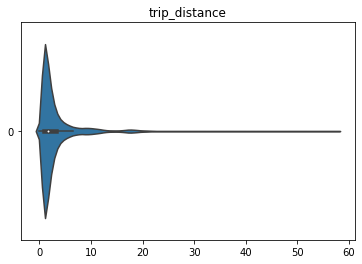

fare_amount
+----+----+----+---+---+---+---+---+----+----+----+----+-----+-----+-----+
|  0%|0.1%|0.5%| 1%| 5%|10%|25%|50%| 75%| 90%| 95%| 99%|99.5%|99.9%| 100%|
+----+----+----+---+---+---+---+---+----+----+----+----+-----+-----+-----+
|0.01| 3.0| 3.5|3.5|4.5|5.0|6.5|9.5|15.0|26.0|37.5|52.0| 60.0| 94.5|825.0|
+----+----+----+---+---+---+---+---+----+----+----+----+-----+-----+-----+



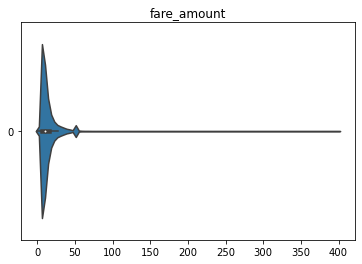

extra
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%|95%|99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
|0.0| 0.0| 0.0|0.0|0.0|0.0|0.0|0.0|0.5|1.0|1.0|1.0|  1.0|  4.5| 5.0|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+



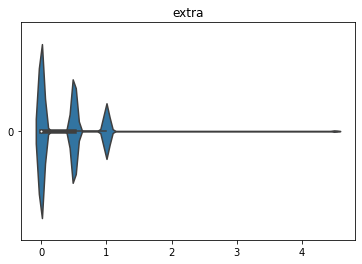

mta_tax
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%|95%|99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
|0.0| 0.0| 0.5|0.5|0.5|0.5|0.5|0.5|0.5|0.5|0.5|0.5|  0.5|  0.5| 0.5|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+



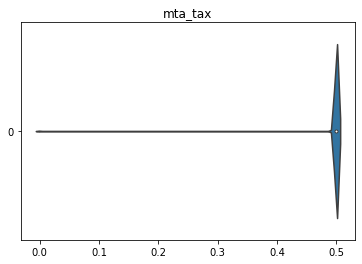

tolls_amount
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+------+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%| 95%| 99%|99.5%|99.9%|  100%|
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+------+
|0.0| 0.0| 0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|5.54|5.76| 5.76|16.26|178.52|
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+------+



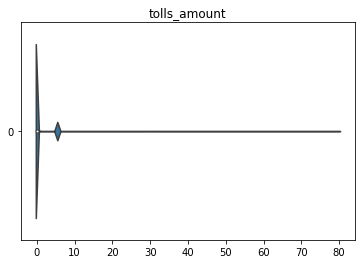

total_amount
+----+----+----+---+----+----+----+-----+----+----+-----+-----+-----+-----+-----+
|  0%|0.1%|0.5%| 1%|  5%| 10%| 25%|  50%| 75%| 90%|  95%|  99%|99.5%|99.9%| 100%|
+----+----+----+---+----+----+----+-----+----+----+-----+-----+-----+-----+-----+
|0.05|4.52|5.16|5.5|6.62|7.54|9.35|12.88|19.1|33.3|50.06|72.92|78.81|120.8|825.0|
+----+----+----+---+----+----+----+-----+----+----+-----+-----+-----+-----+-----+



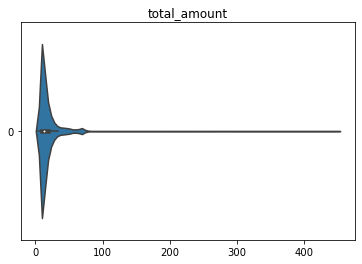

duration_in_min
+---+----+----+---+---+---+---+----+----+----+----+----+-----+------+------+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%| 50%| 75%| 90%| 95%| 99%|99.5%| 99.9%|  100%|
+---+----+----+---+---+---+---+----+----+----+----+----+-----+------+------+
|0.1| 0.1| 1.1|1.7|3.3|4.4|7.0|11.6|18.9|29.2|38.0|62.1| 73.8|1409.6|1439.9|
+---+----+----+---+---+---+---+----+----+----+----+----+-----+------+------+



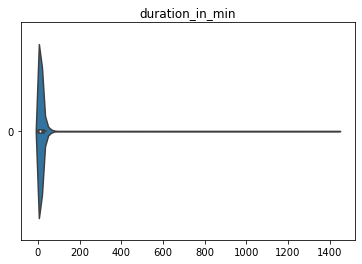

tip_amount
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+------+
| 0%|0.1%|0.5%| 1%|  5%|10%| 25%|50%| 75%| 90%|95%|  99%|99.5%|99.9%|  100%|
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+------+
|0.0| 0.0| 0.0|0.0|0.63|1.0|1.35|2.0|3.05|5.15|8.0|12.61| 15.0|21.58|376.79|
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+------+



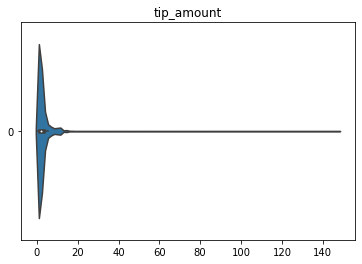

improvement_surcharge
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%|95%|99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+
|0.3| 0.3| 0.3|0.3|0.3|0.3|0.3|0.3|0.3|0.3|0.3|0.3|  0.3|  0.3| 0.3|
+---+----+----+---+---+---+---+---+---+---+---+---+-----+-----+----+



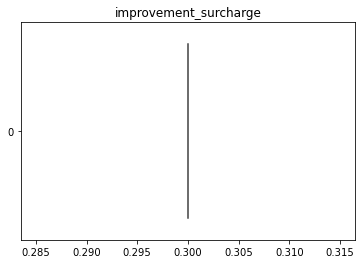

In [12]:
numeric_columns = ['passenger_count', 'trip_distance', 'fare_amount', 
    'extra', 'mta_tax', 'tolls_amount',     
    'total_amount','duration_in_min', 'tip_amount', 'improvement_surcharge']

for column in numeric_columns:    
    print(column)
    prep.show_detailed_percentiles(psdf_taxi, column)
    ax = sns.violinplot(data=df_basic_stats[column], orient='h')
    ax.set_title(column)
    plt.show()   

We remove those outliers that we detect as probably not correct:
- trip_distance values below percentile 1% and above 99.9% are probably not correct
- fare_amount values below percentile 0.1% and above 99.9% are probably not correct
- tolls_amount values above 99.9% are probably not correct
- total_amount values below percentile 0.1% and above 99.9% are probably not correct
- duration_in_min values below percentile 0.5% and above 99.5% are probably not correct
- tip_amount values above 99.9% are probably not correct

In [13]:
dict_remove = {
        "trip_distance":[0.01, 0.999],
        "fare_amount":[0.001, 0.999],
        "tolls_amount":[0.0, 0.999],
        "total_amount":[0.001, 0.999],
        "duration_in_min":[0.005, 0.995],
        "tip_amount":[0.0, 0.999],  
    }

for key_remove in dict_remove:    
    # remove values below percentile
    psdf_taxi = psdf_taxi.withColumn(key_remove,\
        func.when(func.col(key_remove) < psdf_taxi.agg(\
        func.expr(f'percentile({key_remove}, \
        {dict_remove[key_remove][0]})')).collect()[0][0], func.lit(None)).\
        otherwise(func.col(key_remove)))
    
    # remove values above percentile
    psdf_taxi = psdf_taxi.withColumn(key_remove,\
        func.when(func.col(key_remove) > psdf_taxi.agg(\
        func.expr(f'percentile({key_remove}, \
        {dict_remove[key_remove][1]})')).collect()[0][0], func.lit(None)).\
        otherwise(func.col(key_remove)))
        

trip_distance
+---+----+----+----+----+---+----+---+---+----+----+----+-----+-----+-----+
| 0%|0.1%|0.5%|  1%|  5%|10%| 25%|50%|75%| 90%| 95%| 99%|99.5%|99.9%| 100%|
+---+----+----+----+----+---+----+---+---+----+----+----+-----+-----+-----+
|0.3| 0.3|0.31|0.39|0.55|0.7|1.01|1.7|3.2|7.14|10.9|18.8| 20.2|22.54|26.19|
+---+----+----+----+----+---+----+---+---+----+----+----+-----+-----+-----+



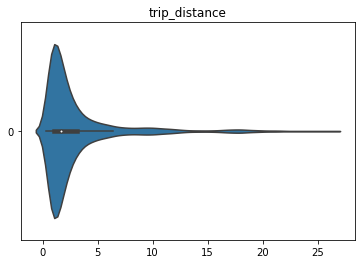

fare_amount
+---+----+----+---+---+---+---+---+----+----+----+----+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%| 75%| 90%| 95%| 99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+---+----+----+----+----+-----+-----+----+
|3.0| 3.0| 3.5|3.5|4.5|5.0|6.5|9.5|15.0|26.0|37.0|52.0| 57.0| 75.0|94.5|
+---+----+----+---+---+---+---+---+----+----+----+----+-----+-----+----+



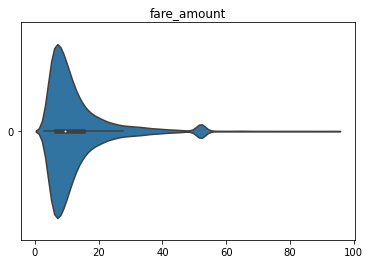

tolls_amount
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+-----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%|50%|75%|90%| 95%| 99%|99.5%|99.9%| 100%|
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+-----+
|0.0| 0.0| 0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|5.54|5.76| 5.76| 12.5|16.26|
+---+----+----+---+---+---+---+---+---+---+----+----+-----+-----+-----+



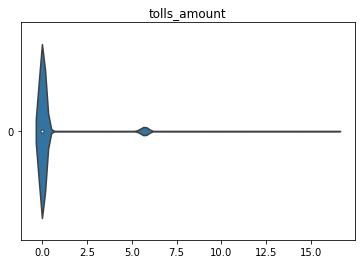

total_amount
+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+-----+
|  0%|0.1%|0.5%|  1%|  5%| 10%| 25%|  50%| 75%|  90%|  95%|  99%|99.5%|99.9%| 100%|
+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+-----+
|4.52| 4.8|5.16|5.59|6.63|7.55|9.35|12.88|19.1|32.85|49.61|71.32|75.96|102.3|120.8|
+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+-----+



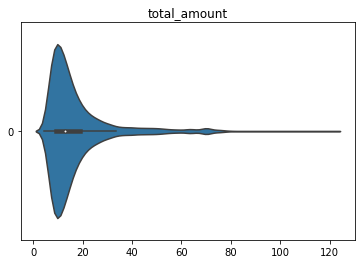

duration_in_min
+---+----+----+---+---+---+---+----+----+----+----+----+-----+-----+----+
| 0%|0.1%|0.5%| 1%| 5%|10%|25%| 50%| 75%| 90%| 95%| 99%|99.5%|99.9%|100%|
+---+----+----+---+---+---+---+----+----+----+----+----+-----+-----+----+
|1.1| 1.2| 1.7|2.0|3.4|4.4|7.0|11.6|18.8|28.7|36.8|55.9| 62.3| 70.7|73.9|
+---+----+----+---+---+---+---+----+----+----+----+----+-----+-----+----+



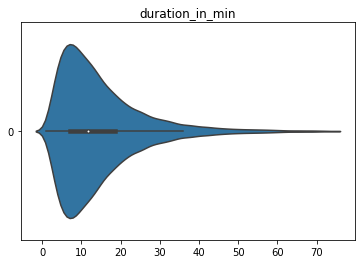

tip_amount
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+-----+
| 0%|0.1%|0.5%| 1%|  5%|10%| 25%|50%| 75%| 90%|95%|  99%|99.5%|99.9%| 100%|
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+-----+
|0.0| 0.0| 0.0|0.0|0.63|1.0|1.35|2.0|3.05|5.08|8.0|12.57| 14.6| 18.2|21.58|
+---+----+----+---+----+---+----+---+----+----+---+-----+-----+-----+-----+



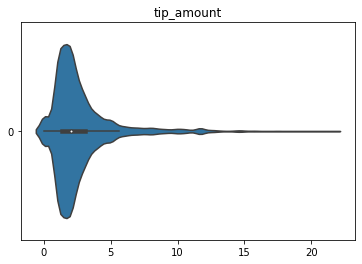

In [14]:
# let's check the distribution after removing outliers
df_basic_stats = psdf_taxi.sample(0.01).toPandas() 
for column in dict_remove:    
    print(column)
    prep.show_detailed_percentiles(psdf_taxi, column)
    ax = sns.violinplot(data=df_basic_stats[column], orient='h')
    ax.set_title(column)
    plt.show()   

### Duplicated values

In [15]:
print(f"Duplicated zone IDs? {(df_zones['LocationID'].duplicated().any())}")
print(f"Duplicated zone shp IDs? {(gdf_zones_shp['LocationID'].duplicated().any())}")
print(f"Duplicated zone shp OBJECTIDs? {(gdf_zones_shp['OBJECTID'].duplicated().any())}")

print(gdf_zones_shp[gdf_zones_shp['LocationID'].duplicated()][['LocationID', 'OBJECTID']])
print(gdf_zones_shp[gdf_zones_shp['LocationID'] != gdf_zones_shp['OBJECTID']][['LocationID', 'OBJECTID']])


Duplicated zone IDs? False
Duplicated zone shp IDs? True
Duplicated zone shp OBJECTIDs? False
     LocationID  OBJECTID
56           56        57
103         103       104
104         103       105
     LocationID  OBJECTID
56           56        57
103         103       104
104         103       105


- we can see that LocationID in SHP has duplicates
- these duplicates coincide with the non related rows with columns OBJECTID and LocationID
- so we can conclude that we should user OBJECTID instead for SHP dataframe

<AxesSubplot:>

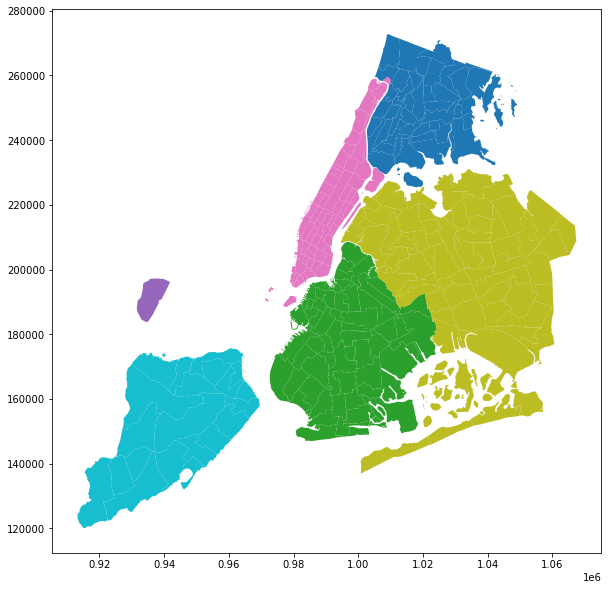

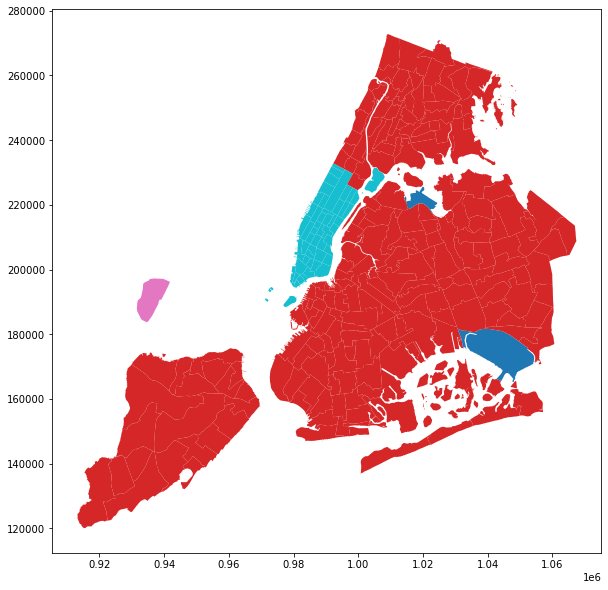

In [16]:
gdf_zones_shp_cp = gdf_zones_shp.merge(
    df_zones[["LocationID", "service_zone"]],
    left_on="OBJECTID", 
    right_on="LocationID")

gdf_zones_shp_cp = gdf_zones_shp_cp.reset_index(drop=True)
gdf_zones_shp_cp.plot(column="borough", figsize=(15, 10),)
gdf_zones_shp_cp.plot(column="service_zone", figsize=(15, 10),)

- Maps do not seem to show any inconsistency with the areas